In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



pd.set_option('display.max_rows', None)

with open('/scratch_tmp/users/k2480846/storage_analysis/data/quota_report.txt', 'r') as file:
    lines = file.readlines()


cleaned_lines = []
for line in lines:
    if not line.startswith('-') and 'Path' not in line:
        cleaned_lines.append(line.strip())

quota_report = [line.split(maxsplit=6) for line in cleaned_lines]


quota_report = pd.DataFrame(quota_report, columns=[
    "Path",
    "Type",
    "Quota (GB)",
    "Usage (GB)",
    "Available (GB)",
    "Usage (%)",
    "Updated"
])
quota_report["Path"] = quota_report["Path"].str.replace(r"^/scratch/(prj|grp)/", "", regex=True)
quota_report["Quota (GB)"] = pd.to_numeric(quota_report["Quota (GB)"])
quota_report["Usage (GB)"] = pd.to_numeric(quota_report["Usage (GB)"])
quota_report["Available (GB)"] = pd.to_numeric(quota_report["Available (GB)"])
quota_report["Usage (GB)"] = pd.to_numeric(quota_report["Usage (GB)"])
quota_report["Type"] = 'HPC' #confirm all projects from ceph_quota are HPC projects
quota_report = quota_report.drop(columns=["Usage (%)","Updated"])

free_projects = quota_report[(quota_report["Quota (GB)"]>=1000) & (quota_report["Quota (GB)"] <= 1024)]

paid_for_projects = quota_report[quota_report["Quota (GB)"]>1024]

paid_for_projects_free_tier_storage = len(paid_for_projects) * 1000
paid_for_projects_total_storage = float(paid_for_projects["Quota (GB)"].sum())
paid_for_projects_paid_storage = paid_for_projects_total_storage - paid_for_projects_free_tier_storage

## usage (GB) for paid projects
used_storage_paid_for_projects = float(paid_for_projects["Usage (GB)"].sum())
unused_storage_paid_for_projects = paid_for_projects_total_storage - float(used_storage_paid_for_projects)


In [2]:
## rosalind group quotas

def convert_storage(value):
    if value.endswith('T'): 
        return float(value.rstrip('T')) * 1000
    elif value.endswith('G'): 
        return float(value.rstrip('G'))
    elif value.endswith('k'):
        return float(value.rstrip('k'))
    else:
        return float(value)

def get_not_covered_by_rosalind(ceph_quota, covered_by_rosalind):
    if(ceph_quota > covered_by_rosalind):
        return ceph_quota - covered_by_rosalind
    else:
        return 0  

rosalind_quotas = pd.read_excel('/scratch_tmp/users/k2480846/storage_analysis/data/rosalind_group_quotas.ods', engine='odf')
rosalind_quotas["quota"] = rosalind_quotas["quota"].apply(convert_storage)
rosalind_quotas["Rosalind Quota"] = rosalind_quotas["quota"]
rosalind_quotas = rosalind_quotas.drop(columns=['gid','filesys','group','grace','files_used','files_quota','files_grace', 'files_limit','limit','used', 'quota'])


## merged ceph_quota and rosalind_quotas and those that are in both remain.

merged_df = pd.merge(quota_report, rosalind_quotas, left_on="Path", right_on="dir", how="outer")
merged_df = merged_df.dropna(subset=["dir","Path"])
merged_df["Covered by Rosalind"] = merged_df[["Quota (GB)", "Rosalind Quota"]].min(axis=1)
merged_df["Not covered by Rosalind"] = merged_df.apply(lambda row : get_not_covered_by_rosalind(row["Quota (GB)"], row["Covered by Rosalind"]), axis=1)

storage_covered_from_migration_from_rosalind = float(merged_df["Covered by Rosalind"].sum())
storage_covered_from_migration_from_rosalind
storage_not_covered_from_migration_from_rosalind = float(merged_df["Not covered by Rosalind"].sum())


covered_completely_by_rosalind = merged_df[merged_df["Not covered by Rosalind"]==0]


In [3]:
rds_quotas = pd.read_csv('/scratch_tmp/users/k2480846/storage_analysis/data/RDS_usage.csv')
rds_quotas["tb_quota"] = rds_quotas.apply(lambda row : row["tb_quota"] * 1000, axis=1)
rds_quotas = rds_quotas.rename(columns={"gb_used": "Usage (GB)", "tb_quota": "Quota (GB)", "share": "Path"})
rds_quotas["Type"] = "RDS"

rds_free_projects = rds_quotas[rds_quotas["Quota (GB)"]<=5000]
rds_paid_projects = rds_quotas[rds_quotas["Quota (GB)"]>5000]

rds_total_storage = float(rds_quotas["Quota (GB)"].sum())

rds_paid_projects_free_tier_storage = len(rds_paid_projects)*5000
rds_paid_projects_total_storage = float(rds_paid_projects["Quota (GB)"].sum())
rds_paid_projects_paid_storage = rds_paid_projects_total_storage - rds_paid_projects_free_tier_storage 


## usage (GB) for paid projects
rds_used_storage_paid_for_projects = float(rds_paid_projects["Usage (GB)"].sum())
rds_unused_storage_paid_for_projects = rds_paid_projects_total_storage - float(rds_used_storage_paid_for_projects)

In [4]:
## recharging register shenanigans

import openpyxl

xl = pd.ExcelFile('/scratch_tmp/users/k2480846/storage_analysis/data/recharging_register.xlsx')
recharging_register = xl.parse("Current projects")
recharging_register["Countdown"] = recharging_register["Countdown"].str.replace(r' days| DAYS', '', regex=True).astype(float)

pending_payment_projects = recharging_register[recharging_register["Countdown"]<0]

up_to_date_projects = recharging_register[recharging_register["Countdown"]>0]

Text(0.5, 1.0, 'Distribution of storage covered by migration from Rosalind and storage not covered')

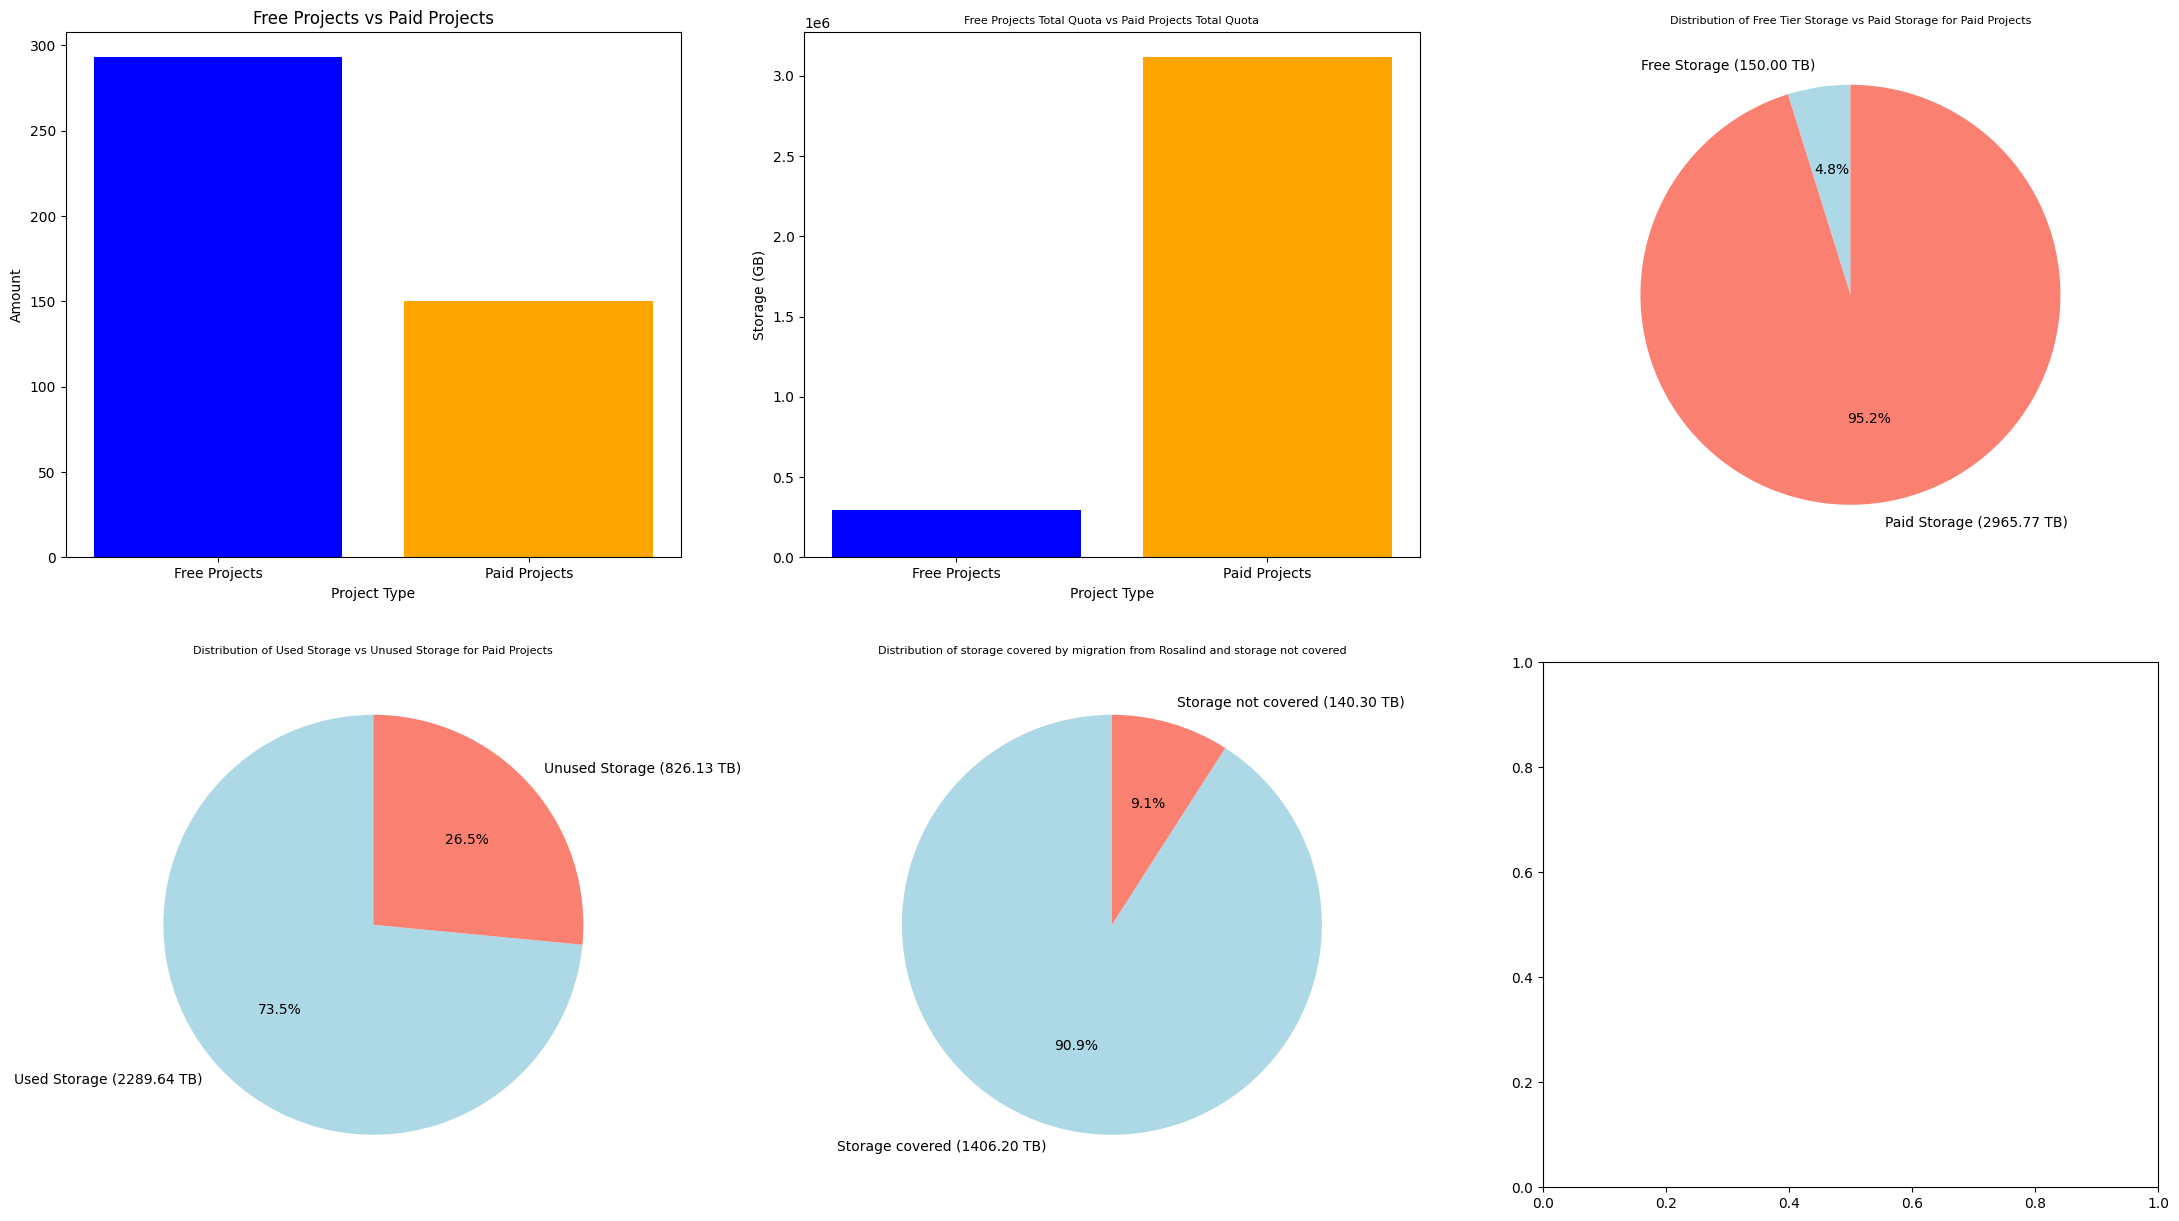

In [15]:
## HPC PROJECT ANALYSIS

fig, axes = plt.subplots(2, 3, figsize=(27, 15)) 

axes[0, 0].bar(['Free Projects', 'Paid Projects'], 
               [len(free_projects), len(paid_for_projects)], 
               color=['blue', 'orange'])
axes[0, 0].set_title("Free Projects vs Paid Projects")
axes[0, 0].set_ylabel("Amount")
axes[0, 0].set_xlabel("Project Type")

axes[0, 1].bar(['Free Projects', 'Paid Projects'], 
               [float(free_projects["Quota (GB)"].sum()), paid_for_projects_total_storage], 
               color=['blue', 'orange'])
axes[0, 1].set_title("Free Projects Total Quota vs Paid Projects Total Quota", fontsize=8)
axes[0, 1].set_ylabel("Storage (GB)")
axes[0, 1].set_xlabel("Project Type")

axes[0, 2].pie([paid_for_projects_free_tier_storage, paid_for_projects_paid_storage], 
               labels=[
                f'Free Storage ({paid_for_projects_free_tier_storage /1000 :.2f} TB)',
                f'Paid Storage ({paid_for_projects_paid_storage /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[0, 2].set_title("Distribution of Free Tier Storage vs Paid Storage for Paid Projects", fontsize=8)


axes[1, 0].pie([used_storage_paid_for_projects, unused_storage_paid_for_projects], 
               labels=[
                f'Used Storage ({used_storage_paid_for_projects /1000 :.2f} TB)', 
                f'Unused Storage ({unused_storage_paid_for_projects /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 0].set_title("Distribution of Used Storage vs Unused Storage for Paid Projects", fontsize=8)


axes[1, 1].pie([storage_covered_from_migration_from_rosalind, storage_not_covered_from_migration_from_rosalind], 
               labels=[
                f'Storage covered ({storage_covered_from_migration_from_rosalind /1000 :.2f} TB)', 
                f'Storage not covered ({storage_not_covered_from_migration_from_rosalind /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 1].set_title("Distribution of storage covered by migration from Rosalind and storage not covered", fontsize=8)


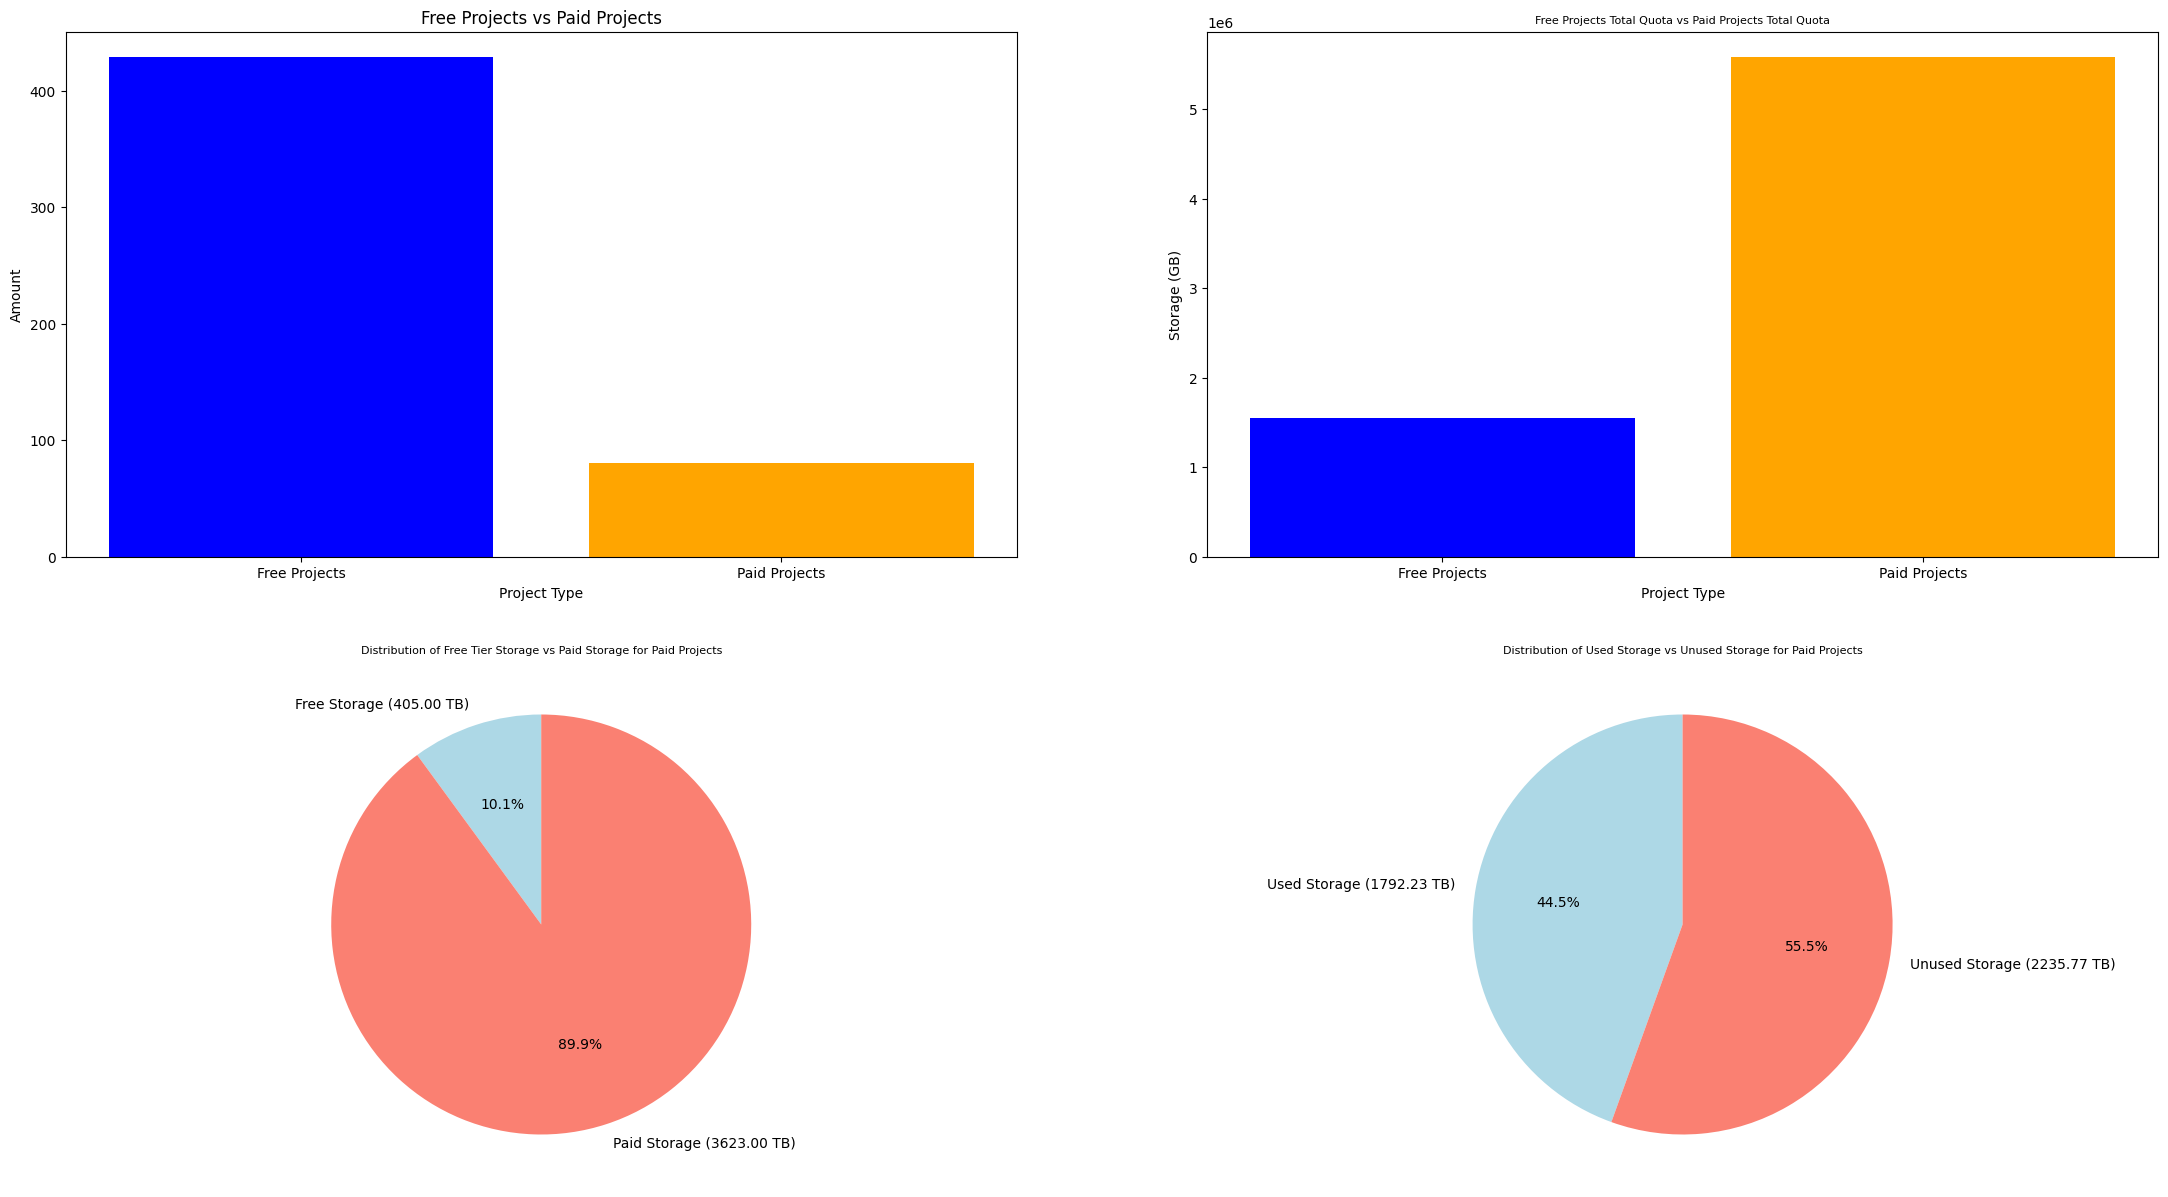

In [20]:
## RDS PROJECT ANALYSIS

fig, axes = plt.subplots(2, 2, figsize=(27, 15)) 

axes[0, 0].bar(['Free Projects', 'Paid Projects'], 
               [len(rds_free_projects), len(rds_paid_projects)], 
               color=['blue', 'orange'])
axes[0, 0].set_title("Free Projects vs Paid Projects")
axes[0, 0].set_ylabel("Amount")
axes[0, 0].set_xlabel("Project Type")

axes[0, 1].bar(['Free Projects', 'Paid Projects'], 
               [float(rds_free_projects["Quota (GB)"].sum()), rds_total_storage], 
               color=['blue', 'orange'])
axes[0, 1].set_title("Free Projects Total Quota vs Paid Projects Total Quota", fontsize=8)
axes[0, 1].set_ylabel("Storage (GB)")
axes[0, 1].set_xlabel("Project Type")

axes[1, 0].pie([rds_paid_projects_free_tier_storage, rds_paid_projects_paid_storage], 
               labels=[
                f'Free Storage ({rds_paid_projects_free_tier_storage /1000 :.2f} TB)',
                f'Paid Storage ({rds_paid_projects_paid_storage /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 0].set_title("Distribution of Free Tier Storage vs Paid Storage for Paid Projects", fontsize=8)


axes[1, 1].pie([rds_used_storage_paid_for_projects, rds_unused_storage_paid_for_projects], 
               labels=[
                f'Used Storage ({rds_used_storage_paid_for_projects /1000 :.2f} TB)', 
                f'Unused Storage ({rds_unused_storage_paid_for_projects /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 1].set_title("Distribution of Used Storage vs Unused Storage for Paid Projects", fontsize=8)

pass

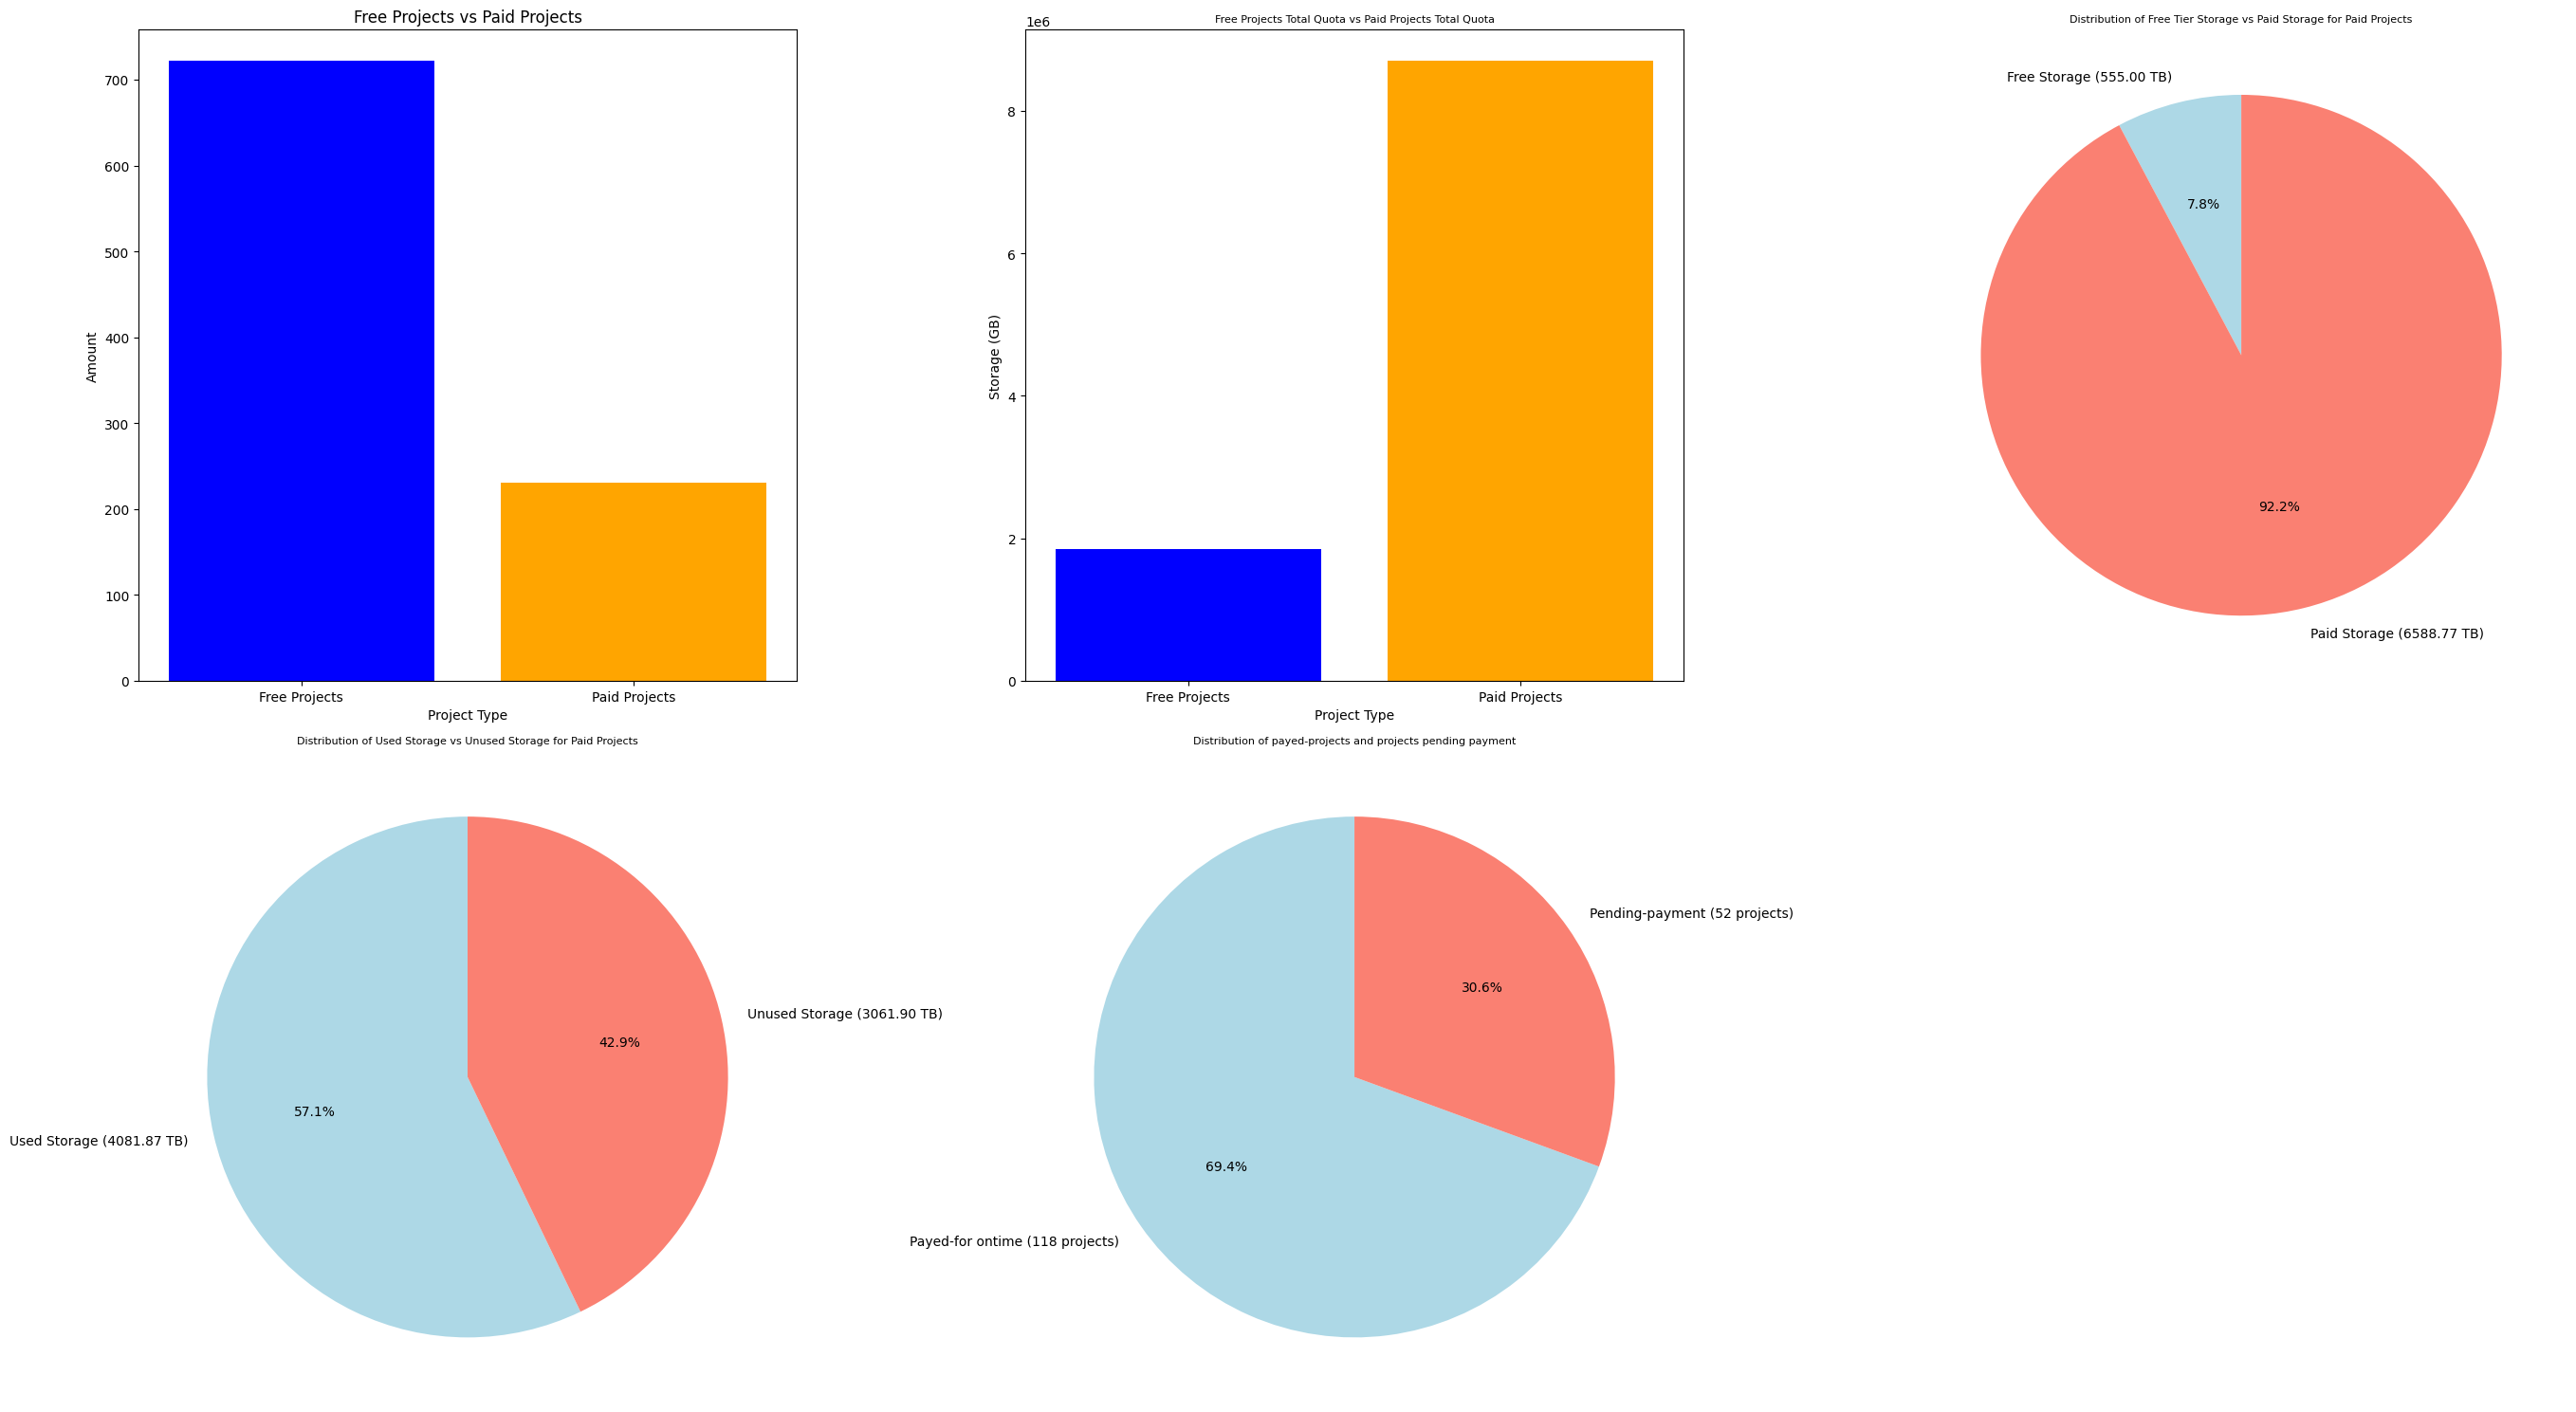

In [26]:
## All project analysis

fig, axes = plt.subplots(2, 3, figsize=(27, 15)) 

axes[0, 0].bar(['Free Projects', 'Paid Projects'], 
               [len(free_projects) + len(rds_free_projects), len(paid_for_projects) + len(rds_paid_projects)], 
               color=['blue', 'orange'])
axes[0, 0].set_title("Free Projects vs Paid Projects")
axes[0, 0].set_ylabel("Amount")
axes[0, 0].set_xlabel("Project Type")

axes[0, 1].bar(['Free Projects', 'Paid Projects'], 
               [float(free_projects["Quota (GB)"].sum()) + float(rds_free_projects["Quota (GB)"].sum()), paid_for_projects_total_storage + rds_total_storage], 
               color=['blue', 'orange'])
axes[0, 1].set_title("Free Projects Total Quota vs Paid Projects Total Quota", fontsize=8)
axes[0, 1].set_ylabel("Storage (GB)")
axes[0, 1].set_xlabel("Project Type")

total_free_storage_paid_projects = paid_for_projects_free_tier_storage + rds_paid_projects_free_tier_storage
total_paid_storage = paid_for_projects_paid_storage + rds_paid_projects_paid_storage
axes[0, 2].pie([total_free_storage_paid_projects, total_paid_storage], 
               labels=[
                f'Free Storage ({total_free_storage_paid_projects /1000 :.2f} TB)',
                f'Paid Storage ({total_paid_storage /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[0, 2].set_title("Distribution of Free Tier Storage vs Paid Storage for Paid Projects", fontsize=8)

total_used_storage_paid_projects = rds_used_storage_paid_for_projects + used_storage_paid_for_projects
total_unused_storage_paid_projects = rds_unused_storage_paid_for_projects + unused_storage_paid_for_projects

axes[1, 0].pie([total_used_storage_paid_projects, total_unused_storage_paid_projects], 
               labels=[
                f'Used Storage ({total_used_storage_paid_projects /1000 :.2f} TB)', 
                f'Unused Storage ({total_unused_storage_paid_projects /1000 :.2f} TB)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 0].set_title("Distribution of Used Storage vs Unused Storage for Paid Projects", fontsize=8)

axes[1, 1].pie([len(up_to_date_projects), len(pending_payment_projects)], 
               labels=[
                f'Payed-for ontime ({len(up_to_date_projects)} projects)', 
                f'Pending-payment ({len(pending_payment_projects)} projects)'
                ], 
               autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'], 
               startangle=90) 
axes[1, 1].set_title("Distribution of payed-projects and projects pending payment", fontsize=8)

fig.delaxes(axes[1, 2])
plt.tight_layout()


In [44]:
## PREPAID QUOTAS

from io import StringIO
import re


rows = parse_markdown("/scratch_tmp/users/k2480846/storage_analysis/data/prepaid_quotas.md")
# write_csv("/scratch_tmp/users/k2480846/storage_analysis/data/prepaid_quotas.csv", rows)


